# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/EhWeqeQsh-9Mr1fneZc9_0sBOBzEdXngvxFJtAlIa-eAgA?e=8ukWwa). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

In [1]:
# Write your answer here and turn the cell type into markdown

### 2. Formulate the business problem, success metrics, and desired ML output.

In [2]:
# Write your answer here and turn the cell type into markdown

### 3. Identify the type of ML problem you’re dealing with.

In [3]:
# Write your answer here and turn the cell type into markdown

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [4]:
import os
from pathlib import Path
from zipfile import ZipFile
import time
import glob
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [5]:
# download the files

# <note: make them all relative, absolute path is not accepted>
base_path = Path('.')
zip_path = base_path/'data_compressed'
csv_base_path = base_path /'data'

#To save models
artifacts_path = base_path / 'artifacts'

#!mkdir -p {csv_base_path}

In [6]:
# How many zip files do we have? write a code to answer it.
count = 0

for path in os.listdir(zip_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(zip_path, path)):
        count += 1
print('Zip File count:', count)

Zip File count: 60


#### Extract CSV files from ZIP files

In [7]:
# from zipfile import ZipFile

# def zip2csv(zipFile_name , file_path):
#     """
#     Extract csv from zip files
#     zipFile_name: name of the zip file
#     file_path : name of the folder to store csv
#     """

#     try:
#         with ZipFile(zipFile_name, 'r') as z: 
#             print(f'Extracting {zipFile_name} ') 
#             z.extractall(path=file_path) 
#     except:
#         print(f'zip2csv failed for {zipFile_name}')

# for i, file in enumerate(zip_files, 1):
#     zip2csv(file, csv_base_path)
#     if i % 10 == 0:
#         print(f'Extracted {i}/{len(zip_files)} zips...')

# print("Files Extracted", csv_base_path.resolve())

In [8]:
# How many csv files have we extracted? write a code to answer it.
csv_count = len(list(csv_base_path.glob('*.csv')))
print(f'Total CSV files: {csv_count}')

Total CSV files: 60


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [9]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [10]:
df_temp = pd.read_csv(csv_base_path/'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv')

**Question**: Print the row and column length in the dataset, and print the column names.

In [11]:
print("Shape:", df_temp.shape)

Shape: (471949, 110)


**Question**: Print the first 10 rows of the dataset.  

In [12]:
df_shape = df_temp.head(10)
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is    Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          30          4  2014-01-30                AA   
1  2014        1      1          31          5  2014-01-31                AA   
2  2014        1      1           1          3  2014-01-01                AA   
3  2014        1      1           2          4  2014-01-02                AA   
4  2014        1      1           3          5  2014-01-03                AA   
5  2014        1      1           4          6  2014-01-04                AA   
6  2014        1      1           5          7  2014-01-05                AA   
7  2014        1      1           6          1  2014-01-06                AA   
8  2014        1      1           7          2  2014-01-07                AA   
9  2014        1      1           8          3  2014-01-08                AA   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0      

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [13]:
# Enter your code here
print("\nColumn Names:\n", list(df_temp.columns))


Column Names:
 ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Flights', 'Distance', 'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime',

In [14]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [15]:
# Enter your code here
del_columns = [col for col in df_temp.columns if 'Del' in col]

print(f"Total columns containing 'Del': {len(del_columns)}\n")
for c in del_columns:
    print(c)

Total columns containing 'Del': 14

DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
DivArrDelay


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [16]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", df_temp.shape)
print("The years in this dataset are: ", sorted(df_temp['Year'].dropna().unique().tolist()))
print("The months covered in this dataset are: ", sorted(df_temp['Month'].dropna().unique().tolist()))
print("The date range for data is :" , df_temp['FlightDate'].min(), " to ", df_temp['FlightDate'].max())
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].dropna().unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].dropna().unique()))

The #rows and #columns are  (471949, 110)
The years in this dataset are:  [2014]
The months covered in this dataset are:  [1]
The date range for data is : 2014-01-01  to  2014-01-31
The airlines covered in this dataset are:  ['AA', 'AS', 'DL', 'EV', 'B6', 'F9', 'FL', 'HA', 'MQ', 'US', 'OO', 'VX', 'WN', 'UA']
The Origin airports covered are:  ['DFW', 'ICT', 'MIA', 'BLI', 'PDX', 'OGG', 'OAK', 'SMF', 'KOA', 'HNL', 'SJC', 'SEA', 'SAN', 'LIH', 'ANC', 'DCA', 'EWR', 'LAX', 'MCO', 'BOS', 'ORD', 'FLL', 'MSP', 'PHL', 'BET', 'ADQ', 'SCC', 'BRW', 'FAI', 'KTN', 'JNU', 'CDV', 'YAK', 'SIT', 'PSG', 'WRG', 'OME', 'OTZ', 'PHX', 'SFO', 'PSP', 'SNA', 'BUR', 'ONT', 'LAS', 'TUS', 'AUS', 'DEN', 'SAT', 'GEG', 'SLC', 'IAH', 'ATL', 'STL', 'MCI', 'ADK', 'CVG', 'BOI', 'VPS', 'SDF', 'PBI', 'LGA', 'JFK', 'CHS', 'BNA', 'BTR', 'BHM', 'ECP', 'TPA', 'RSW', 'DTW', 'BWI', 'CAE', 'MKE', 'CLE', 'CMH', 'MEM', 'ALB', 'COS', 'MSN', 'BDL', 'FSD', 'GSP', 'JAN', 'PNS', 'FAY', 'CLT', 'HRL', 'IAD', 'AGS', 'BUF', 'DAY', 'LIT', 'SJU

In [17]:
print("The Destination airports covered are: ", list(df_temp['Dest'].dropna().unique()))

The Destination airports covered are:  ['ICT', 'DFW', 'TPA', 'OGG', 'SJC', 'KOA', 'SMF', 'SEA', 'PDX', 'OAK', 'HNL', 'SAN', 'ANC', 'LIH', 'BLI', 'DCA', 'LAX', 'EWR', 'MCO', 'BOS', 'ORD', 'PHL', 'FLL', 'MSP', 'BET', 'ADQ', 'SCC', 'BRW', 'FAI', 'KTN', 'JNU', 'YAK', 'CDV', 'SIT', 'PSG', 'WRG', 'OME', 'OTZ', 'PHX', 'SFO', 'PSP', 'SNA', 'BUR', 'ONT', 'LAS', 'TUS', 'AUS', 'DEN', 'GEG', 'SAT', 'SLC', 'IAH', 'ATL', 'STL', 'MCI', 'ADK', 'LGA', 'BOI', 'JFK', 'BWI', 'VPS', 'PBI', 'DTW', 'MSY', 'RDU', 'CMH', 'MDW', 'SRQ', 'GSP', 'GRR', 'CAE', 'CHS', 'MKE', 'JAN', 'GSO', 'BHM', 'MEM', 'PWM', 'ECP', 'IAD', 'CLE', 'CLT', 'RSW', 'MIA', 'IND', 'CVG', 'MSN', 'BDL', 'PNS', 'SJU', 'HRL', 'BUF', 'DAY', 'BNA', 'LIT', 'EYW', 'CAK', 'TYS', 'PIT', 'RIC', 'GPT', 'ABQ', 'OMA', 'TUL', 'ROC', 'STT', 'BTR', 'FNT', 'OKC', 'ORF', 'TLH', 'HSV', 'DAB', 'SAV', 'BZN', 'JAX', 'SDF', 'EGE', 'MYR', 'FAY', 'MLB', 'FAR', 'ELP', 'HOU', 'RNO', 'PVD', 'SYR', 'MOB', 'HDN', 'AGS', 'LEX', 'FSD', 'BIL', 'JAC', 'CHA', 'TRI', 'ILM', '

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [18]:
counts = pd.DataFrame({
    'Origin': df_temp['Origin'].value_counts(),
    'Destination': df_temp['Dest'].value_counts()
})
counts

,Origin,Destination
ABE,135,137
ABI,243,244
ABQ,1910,1909
ABR,62,62
ABY,89,89
...,...,...
VPS,402,401
WRG,62,62
XNA,826,831
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [19]:
counts['Total'] = counts['Origin'] + counts['Destination']
counts.sort_values(by='Total',ascending=False).head(15)# Enter your code here

,Origin,Destination,Total
ATL,30796,30784,61580
DFW,23488,23482,46970
ORD,21497,21529,43026
LAX,18481,18474,36955
DEN,17977,17955,35932
IAH,14581,14569,29150
SFO,13550,13539,27089
PHX,13343,13335,26678
LAS,11050,11052,22102
CLT,9768,9777,19545


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [20]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty dataframe
    df = pd.DataFrame()

    for file in csv_files:
        temp_df = pd.read_csv(file, low_memory=False)

        # keeping only existing columns
        keep_cols = [c for c in filter_cols if c in temp_df.columns]
        temp_df = temp_df[keep_cols]

        # apply subsetting
        for col, vals in zip(subset_cols, subset_vals):
            if col in temp_df.columns:
                temp_df = temp_df[temp_df[col].isin(vals)]

        # concatenate with main df here finally
        df = pd.concat([df, temp_df], ignore_index=True)

    # save combined dataframe
    df.to_csv(file_name, index=False)
    print("Combined data shape:", df.shape)
    print("Saved as:", file_name)

    return df

In [21]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [22]:
"""
start = time.time()

csv_files = sorted(csv_base_path.glob('*.csv'))
combined_csv_filename = f"{base_path}combined_files.csv"

#calling function to combine csv
data = combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)

print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')
"""

'\nstart = time.time()\n\ncsv_files = sorted(csv_base_path.glob(\'*.csv\'))\ncombined_csv_filename = f"{base_path}combined_files.csv"\n\n#calling function to combine csv\ndata = combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)\n\nprint(f\'csv\'s merged in {round((time.time() - start)/60,2)} minutes\')\n'

#### Load dataset

Load the combined dataset.

In [23]:
data = pd.read_csv('.combined_files.csv')# Enter your code here to read the combined csv file.

Print the first 5 records.

In [24]:
print(data.head(5))

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX      2145.0        0.0       0.0   
1    DFW          TX  ATL        GA       945.0        0.0       0.0   
2    ATL          GA  DEN        CO      1855.0        0.0       0.0   
3    ATL          GA  PHX        AZ      1634.0        0.0       0.0   
4    PHX          AZ  ATL        GA       700.0        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  ArrDel15  AirTime  
0     689.0

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [25]:
years = [int(y) for y in data['Year'].unique()]
months = [int(m) for m in data['Month'].unique()]

In [26]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", data.shape[0], " and ", data.shape[1])
print("The years in this dataset are: ", years)
print("The months covered in this dataset are: ", months)
print("The date range for data is :" , min(data['FlightDate']), " to ", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].dropna().unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))

The #rows and #columns are  1605543  and  20
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [27]:
data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True)

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [28]:
# Enter your code here
print(data.isnull().sum(axis=0))

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               1
Cancelled                2
Diverted                 2
Distance                 2
DistanceGroup            2
ArrDelay             21947
ArrDelayMinutes      21948
is_delay             21948
AirTime              21948
dtype: int64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [29]:
### Remove null columns
# keep only rows where ArrDelay, ArrDelayMinutes, and AirTime are not null
data = data[~data['ArrDelay'].isnull()]
data = data[~data['ArrDelayMinutes'].isnull()]
data = data[~data['AirTime'].isnull()]

print("New shape after removing nulls:", data.shape)

New shape after removing nulls: (1583595, 20)


Get the hour of the day in 24-hour time format from CRSDepTime.

In [30]:
data['DepHourofDay'] = (data['CRSDepTime'] // 100).astype(int)
#prinitng result
data[['CRSDepTime', 'DepHourofDay']].head()

,CRSDepTime,DepHourofDay
0,2145.0,21
1,945.0,9
2,1855.0,18
3,1634.0,16
4,700.0,7


## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

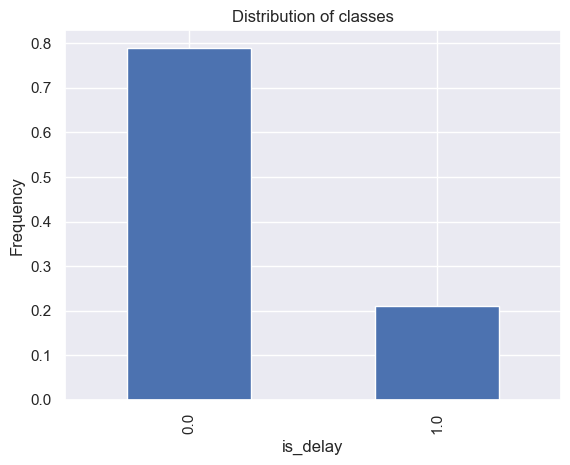

In [31]:
(data.groupby('is_delay').size() / len(data)).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

The bar plot shows that most of the aircraft in the dataset were not delayed, and only a tiny number were delayed by more than 15 minutes. In particular, about 75–80% of flights are on time (is_delay = 0.0), while only 20–25% are late (is_delay = 1.0). This illustrates that the dataset is not balanced, with a lot more flights that aren't delayed than planes that are. This is normal for airline data in the actual world. This kind of imbalance should be taken into account when training the model to avoid bias toward forecasting "no delay".

**Questions**: 

- Which months have the most delays?

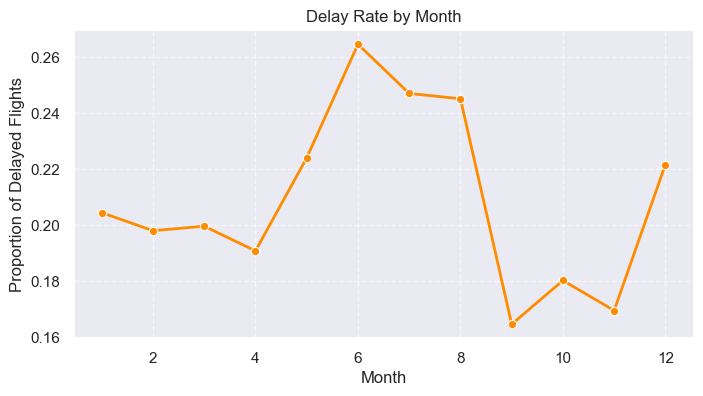

In [32]:
plt.figure(figsize=(8,4))
sns.lineplot(x=data.groupby('Month')['is_delay'].mean().index,
             y=data.groupby('Month')['is_delay'].mean().values,
             marker='o', color='darkorange', linewidth=2)
plt.title('Delay Rate by Month')
plt.xlabel('Month')
plt.ylabel('Proportion of Delayed Flights')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The line plot depicts how the percentage of flights that are late changes throughout the course of the year. The graph shows that flight delays are rather modest from January to April, then go up quickly and peak around June, when they reach their greatest level of nearly 26%. After then, the rate of delays goes down a little in July and August and a lot in September, when there are the least delays of the year.  Delays start to go up again at the end of the year (November–December).  This pattern shows that flight delays happen most often in the middle of the year, maybe because there are more people traveling, the weather is bad, or there are too many planes in the air. They happen the least often in the early fall.

**Questions**: 

- What time of the day has the most delays?

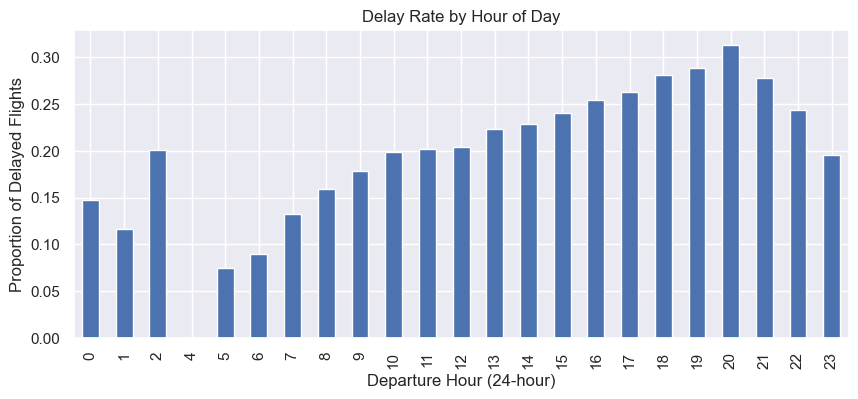

In [33]:
data.groupby('DepHourofDay')['is_delay'].mean().plot(kind='bar', figsize=(10,4))
plt.title('Delay Rate by Hour of Day')
plt.ylabel('Proportion of Delayed Flights')
plt.xlabel('Departure Hour (24-hour)')
plt.show()

The "Delay Rate by Hour of Day" bar chart shows that delays get worse as the day goes on. Flights that leave early in the morning (before 6 AM) are the least likely to be delayed, with rates frequently below 10–15%. The delay rate rises progressively during the afternoon and peaks around 8 PM–9 PM, when more than 30% of flights are delayed. This pattern implies that planes that leave later are more likely to be delayed, probably because of delays from earlier flights and busier evening air traffic schedules.

**Questions**: 

- What day of the week has the most delays?

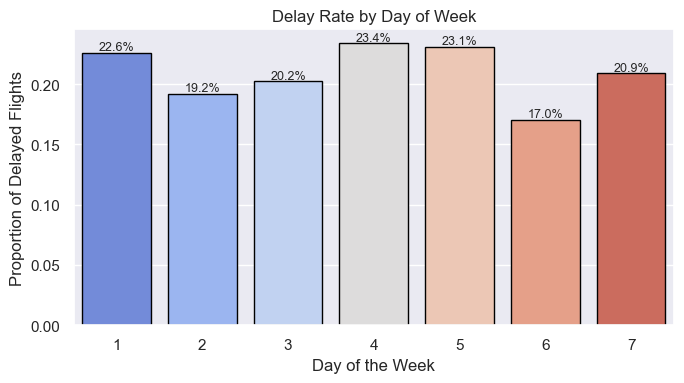

In [34]:
day_delay = data.groupby('DayOfWeek')['is_delay'].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='DayOfWeek', y='is_delay', data=day_delay, palette='coolwarm', edgecolor='black')

# adding labels on top of each bar
for i, v in enumerate(day_delay['is_delay']):
    plt.text(i, v + 0.002, f"{v*100:.1f}%", ha='center', fontsize=9)

plt.title('Delay Rate by Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Proportion of Delayed Flights')
plt.tight_layout()
plt.show()

The "Average Delay Rate by Day of Week" figure shows that Wednesday (Day 4) and Thursday (Day 5) have the most delays, about 23–23.5%. Monday (Day 1) comes in second with 22.6%. Saturday has the lowest delay rate (17%), which means that things run more smoothly and schedules are less busy on weekends. So, flights in the middle of the week are most likely to be late, maybe because more people are traveling for work and the flight schedules are busier.

**Questions**: 


- Which airline has the most delays?


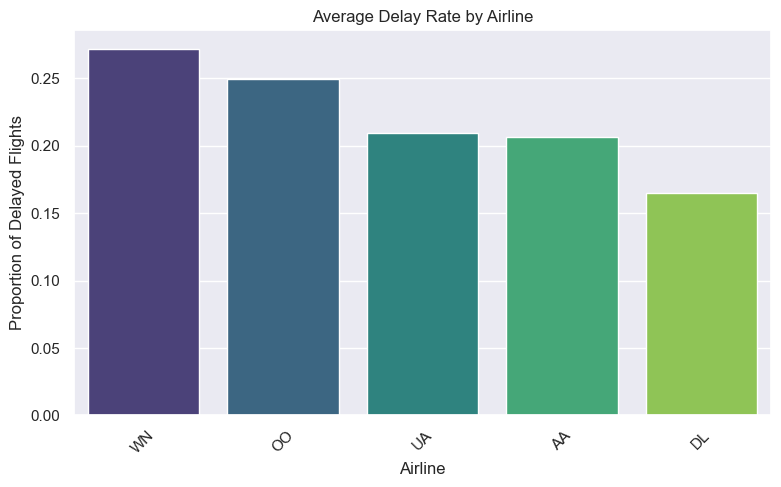

In [35]:
plt.figure(figsize=(9,5))
sns.barplot(x=data.groupby('Reporting_Airline')['is_delay'].mean().sort_values(ascending=False).index,
            y=data.groupby('Reporting_Airline')['is_delay'].mean().sort_values(ascending=False).values,
            palette='viridis')
plt.title('Average Delay Rate by Airline')
plt.ylabel('Proportion of Delayed Flights')
plt.xlabel('Airline')
plt.xticks(rotation=45)
plt.show()

The "Average Delay Rate by Airline" figure reveals that WN has the most delayed flights (about 27%), followed by OO and UA. DL has the fewest delayed flights (about 18%). This suggests that WN has the greatest delays, which could be because it has a lot of flights and tight turnaround times. On the other hand, DL is better at keeping its operations on time.

**Questions**: 

- Which origin and destination airports have the most delays?

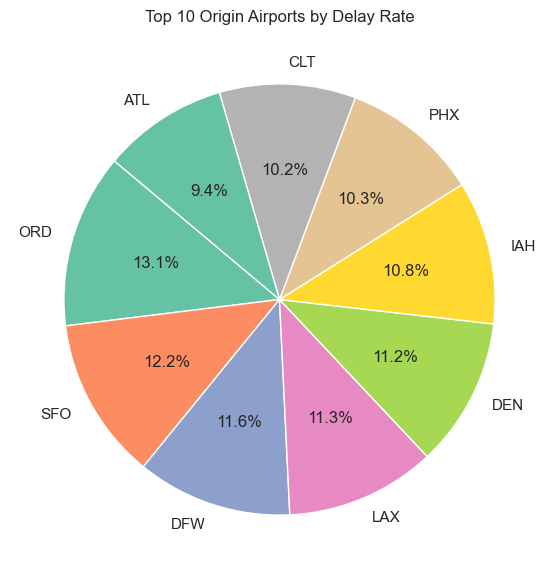

In [36]:
origin_delay = data.groupby('Origin')['is_delay'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(7,7))
plt.pie(origin_delay.values, labels=origin_delay.index, autopct='%1.1f%%',
        startangle=140, colors=sns.color_palette('Set2', 10))
plt.title('Top 10 Origin Airports by Delay Rate')
plt.show()

The pie chart shows "Top 10 Origin Airports by Delay Rate" reveals that ORD has the biggest share of delays (13.1%), followed by SFO of (12.2%) and DFW (11.6%). Airports like ATL (9.4%) and CLT (10.2%) have smaller percentages. This means that big hub airports like Chicago and San Francisco have a lot of traffic and changing weather are more likely to have delays.

**Questions**: 

- Is flight distance a factor in the delays?

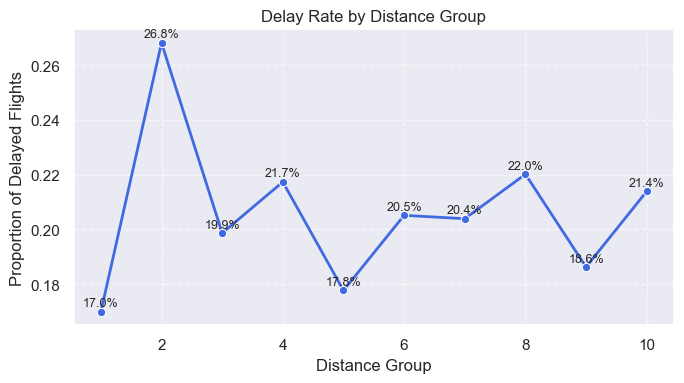

In [37]:
dist_delay = data.groupby('DistanceGroup')['is_delay'].mean().reset_index()

# Simple but clear line plot to show trend
plt.figure(figsize=(7,4))
sns.lineplot(x='DistanceGroup', y='is_delay', data=dist_delay, marker='o', color='royalblue', linewidth=2)

# Add labels for each point
for x, y in zip(dist_delay['DistanceGroup'], dist_delay['is_delay']):
    plt.text(x, y + 0.002, f"{y*100:.1f}%", ha='center', fontsize=9)

plt.title('Delay Rate by Distance Group')
plt.xlabel('Distance Group')
plt.ylabel('Proportion of Delayed Flights')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The "Delay Rate by Distance Group" graphic reveals an irregular pattern, with delay rates going up and down between 17% and 27%. The second distance group has the longest average delay (26.8%), while the others change without a clear pattern. This means that the distance of the flight alone is not a good reason for delays. Operational or geographical issues, such as airport congestion and scheduling, probably have a bigger effect than trip length.

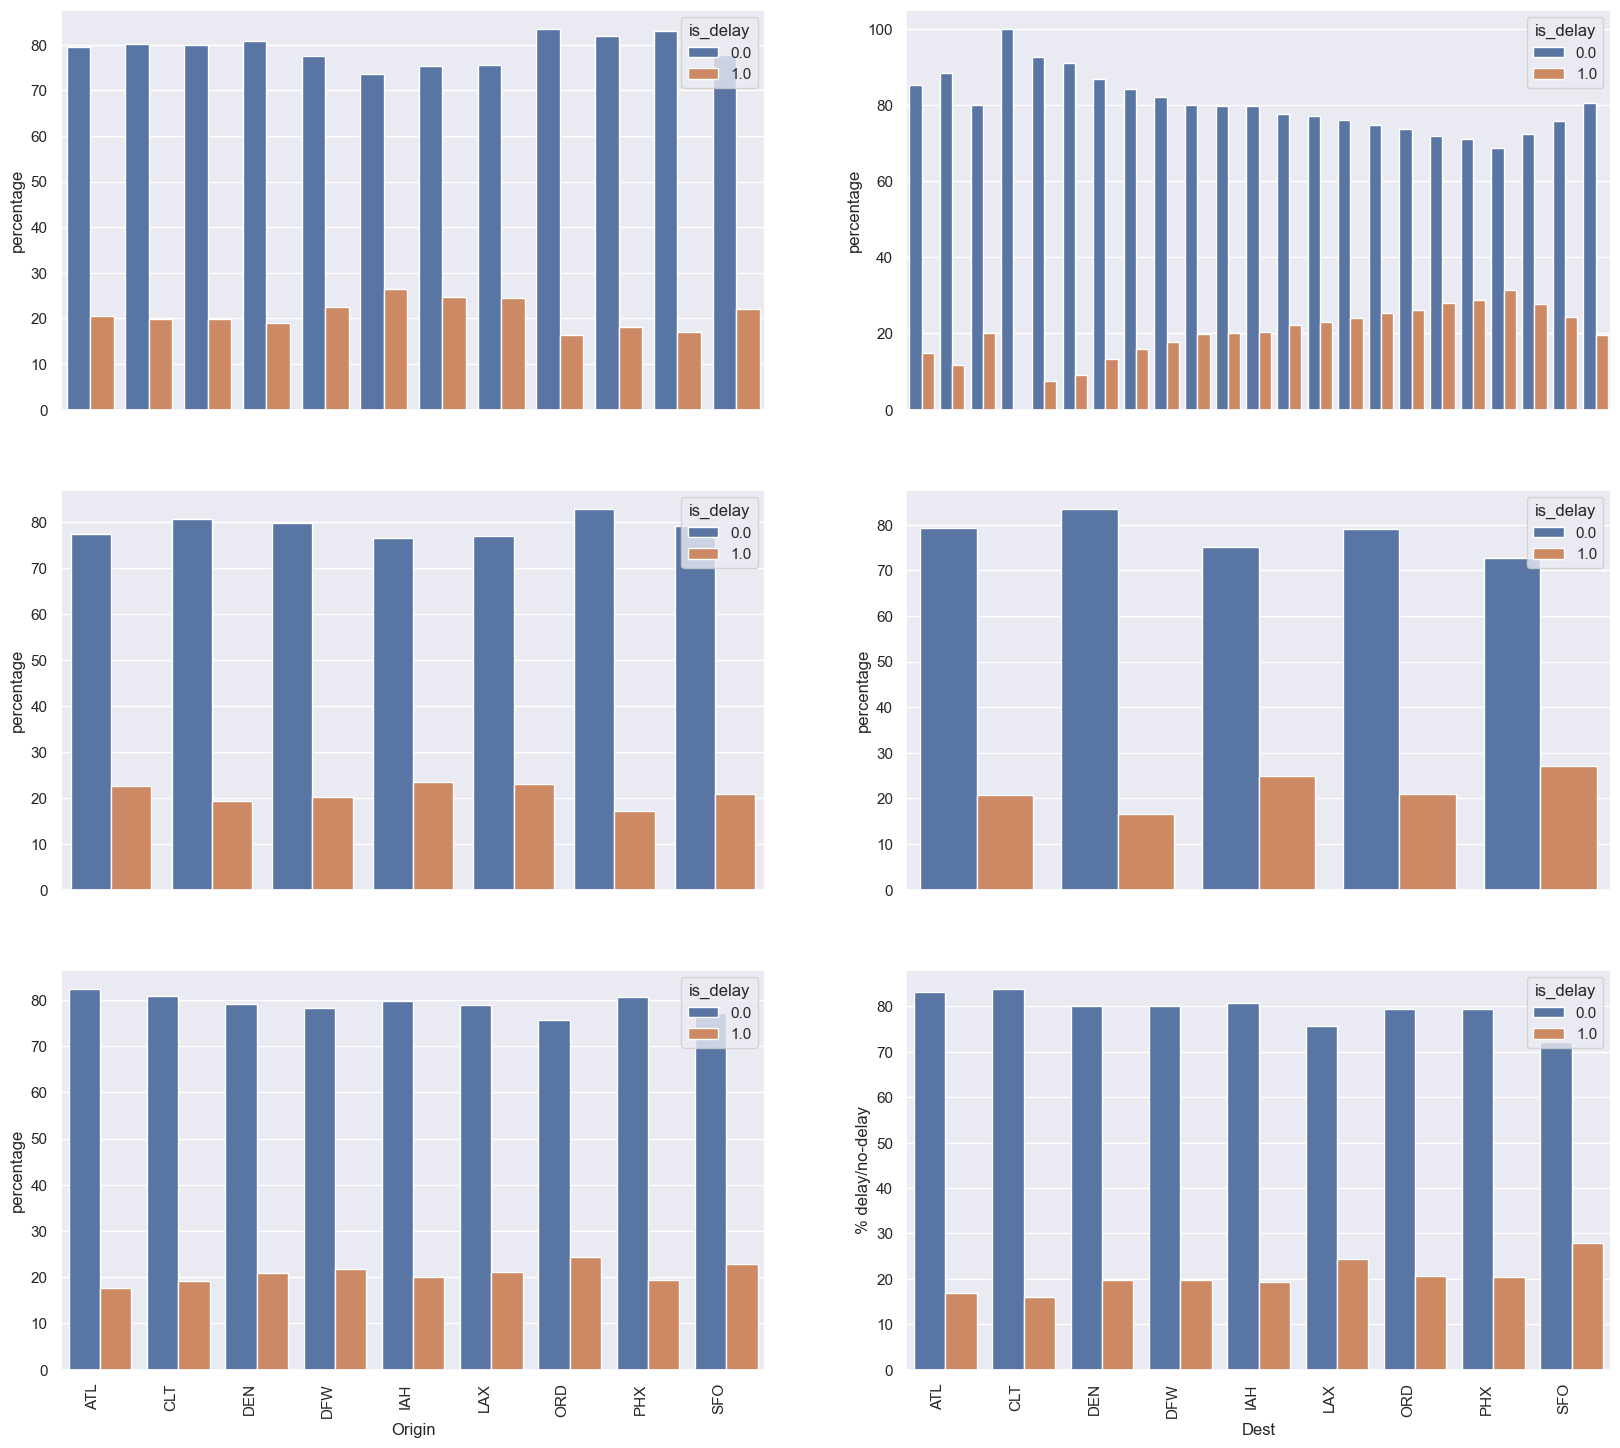

In [38]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

When we look at the combined bar plots (which show the percentages of delays for both the origin and destination), we can see that big hub airports like ATL, DFW, ORD, LAX, and SFO always have a greater percentage of delayed flights. The orange bars show flights that are late. Delays account for about 20–25% of all flights at most airports. This consistent pattern across several airports shows that airport congestion and network connectivity are more important than distance or time alone when it comes to how often delays happen.

Source: Analysis from above EDA questions

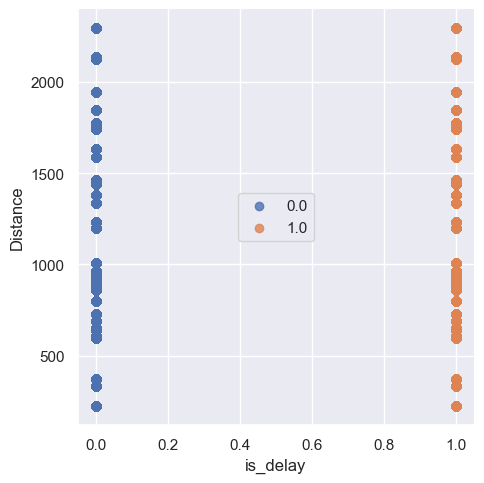

In [39]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

This scatter plot shows the relationship between travel distance and whether or not the flight was delayed (is_delay). The blue dots (0.0) show planes that left on time, whereas the orange dots (1.0) show flights that were late. It looks like both groups are spread out over similar distances, from extremely short trips of less than 500 miles to large flights of more than 2000 miles. There is no clear trend going up or down, and both delayed and non-delayed flights are spread out very fairly throughout all distances.

Moreover, this suggests that the distance of the flight doesn't seem to have a discernible effect on the chance of a delay. In other words, both short- and long-distance flights are delayed at about the same rate. This means that things like airport congestion. Hence, The time of day or airline operations are significantly more likely to cause delays than the distance traveled.

### Features

Look at all the columns and what their specific types are.

In [40]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [41]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime           float64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup        float64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [42]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest']
for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [43]:
# create dummy variables one-hot encoding for categorical columns
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data = pd.concat([data, data_dummies], axis=1)
data.drop(categorical_columns, axis=1, inplace=True)

print("New data shape after encoding:", data.shape)
data.head()

New data shape after encoding: (1583595, 72)


,is_delay,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Origin_PHX,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO
0,0.0,689.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.0,731.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1199.0,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,0.0,1587.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


Check the length of the dataset and the new columnms.

In [44]:
print("Number of rows in dataset:", len(data))
print("Number of columns after encoding:", len(data.columns))

Number of rows in dataset: 1583595
Number of columns after encoding: 72


In [45]:
print("\nColumn names:\n", data.columns)


Column names:
 Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [46]:
data.rename(columns={'is_delay': 'target'}, inplace=True)

In [47]:
#data.to_csv('combined_csv_v1.csv', index=False)

#print("Combined CSV file saved successfully as 'combined_csv_v1.csv'")

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [48]:
X = data.drop(columns=['target'])
y = data['target'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

X_train.shape, X_test.shape

((1266876, 71), (316719, 71))

### Baseline classification model

In [49]:
baseline_model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
baseline_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=200, solver='liblinear')

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [50]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    # annotate the cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)
    plt.colorbar()
    plt.show()
    return cm    

In [51]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    auc = metrics.roc_auc_score(test_labels, target_predicted)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

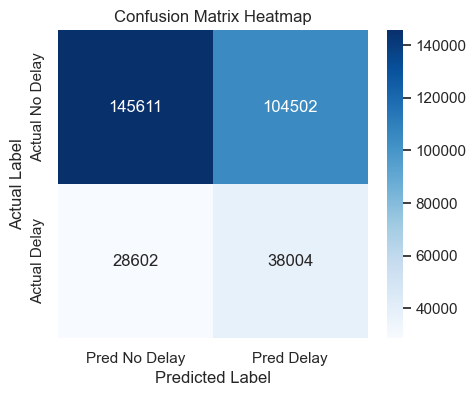

In [52]:
target_predicted = baseline_model.predict(X_test)
cm = confusion_matrix(y_test, target_predicted)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred No Delay', 'Pred Delay'],
            yticklabels=['Actual No Delay', 'Actual Delay'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

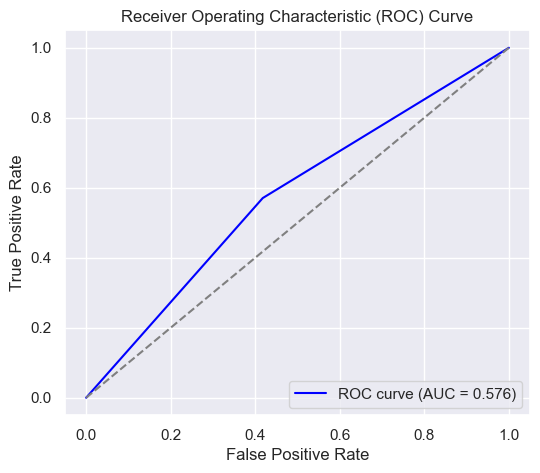

In [53]:
target_predicted = baseline_model.predict(X_test)

plot_roc(y_test, target_predicted)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

1. It suggests the model is generalizing if the metrics for test set (AUC = 0.576) are near to the training results, but the overall performance is poor. However, if the training accuracy was considerably greater, it could suggest that the model learnt patterns that were only true for the training data and didn't work well with the new test data.

2. So far from confusion matrix might make accuracy look good because there are so many no delay examples that were properly predicted. Apparently, the model probably creates a lot of inaccurate delay estimates. Hence the precision for delay is probably low. Similarly, there were a lot of real delays that were missed as "false negatives", hence the recall sensitivity for "Delay" is similarly low. Concluding that, this imbalance makes the model more likely to predict "No Delay" which is what usually happens when one class is more common in the dataset.

3. From a business point of view, the model's AUC of 0.576 demonstrates that it does a little better than random guessing (0.5). This is not enough for predicting flight delays because the model doesn't always correctly highlight possible delays. The future version could make things better by adding:
- By adding feature engineering include things like weather data, traffic at the airports where it leaves and arrives.
- By model tuning, use of tree-based models like Random Forest or XGBoost, which are better at handling non-linear patterns.


**Question**: What can you summarize from the confusion matrix?


From the confusion matrix:

True Negatives (No Delay predicted correctly): 145,611

False Positives (Predicted Delay but actually No Delay): 104,502

False Negatives (Predicted No Delay but actually Delay): 28,602

True Positives (Delay predicted correctly): 38,004

In brief. this suggests that the model can properly identify most flights that are not delayed, but it has a harder time forecasting flights that are delayed. The model may have trouble telling the difference between delayed and on-time flights since there are too many "no delay" cases in the dataset. Hence, to make things more accurate and reliable, we need:- 
1) more balanced data
2) more predictive features
3) better predicitve models


# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitHub repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitHub account, and ensure it is public.


In [ ]:
### Provide a link for your GitHub repository here

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [ ]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = # Enter your code here 

Weather data was fetched from [this link](https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31).
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [ ]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [ ]:
weather = pd.read_csv(<CODE>) # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = # Enter your code here 
weather['airport'] = # Enter your code here 

Create another column called `MONTH` from the `DATE` column.

In [ ]:
weather['MONTH'] = weather[<CODE>].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [ ]:
weather.SNOW.fillna(<CODE>, inplace=True)# Enter your code here
weather.SNWD.fillna(<CODE>, inplace=True)# Enter your code here
weather.isna().sum()

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [ ]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = # Enter your code here 
TMAX_idx = # Enter your code here 
TMIN_idx = # Enter your code here 
TAVG_idx

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [ ]:
weather_impute = weather.groupby([<CODE>]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

Merge the mean data with the weather data.

In [ ]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [ ]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [ ]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [ ]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [ ]:
sum(data.isna().any())

In [ ]:
data_orig.columns

Convert the categorical data into numerical data using one-hot encoding.

In [ ]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [ ]:
data_dummies = # Enter your code here

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [ ]:
data.columns

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [ ]:
data.rename(columns = {<CODE>:<CODE>}, inplace=True )# Enter your code here

In [ ]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B

Create the training and testing sets again.

In [ ]:
# Enter your code here

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [ ]:
# Instantiate another logistic regression model
classifier2 = # Enter your code here

In [ ]:
# Enter your code here

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

In [ ]:
# Enter answer here and turn the cell type into markdown


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

In [ ]:
# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

In [ ]:
# write your answers here